In [1]:
import sys
import miner2 
import miner2.preprocess
import miner2.mechanistic_inference
import miner2.miner
import pandas as pd
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import dill
import pickle
import seaborn as sb
import time

%matplotlib inline

tf_2_genes_path = '../miner2/miner2/data/tfbsdb_tf_to_genes.pkl' # location of tfbs_db
results_dir='./results/GSM3587977_AML707B/'

2019-08-16 13:13:32 	 hello from miner2 version 0.0.9


In [ ]:
def get_gene_set():
    # get all unique gene Ensembl ids from tfbsdb database
    with open(tf_2_genes_path, 'rb') as f:
        tf_2_genes = pickle.load(f)
    
    gene_set = set()
    for key in tf_2_genes:
        value = tf_2_genes[key]
        gene_set.add(key)
        gene_set.update(value)
    return gene_set

def get_ensembl_protein_coding_genes():
    ensembl_df = pd.read_csv('/home/aliu/Projects/causalAssociation/src/mart_export.txt', sep=',', header = 0, index_col = None, engine='python')
    return set(ensembl_df['Gene name']), set(ensembl_df['Gene stable ID'])

def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K:
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K

def comparator(x, y):
    if (x[1][0] != y[1][0]):
        return x[1][0] - y[1][0]
    return x[1][1] - y[1][1]

def select_ensembl_id(gene_ids):
    # select single ensembl_id from list of ensembl_ids
    for gene_id in gene_ids:
        if gene_id not in ensembl_id_set or gene_id not in gene_set:
            gene_ids.remove(gene_id)
            
    if len(gene_ids) == 0:
        return None
    elif len(gene_ids) == 1:
        return gene_ids[0]
            
    with open(tf_2_genes_path, 'rb') as f:
        tf_2_genes = pickle.load(f)
    
    tracker = {} # count number of times gene id is tf or affected by tf
    for gene_id in gene_ids:
        tracker[gene_id] = [0,0] #[tf, affected by tf]
    for key in tf_2_genes:
        if key in tracker:
            tracker[gene_id][0] += 1
        for affected_gene in tf_2_genes[key]:
            if affected_gene in tracker:
                tracker[affected_gene][1] += 1
    
    # return most active gene id in tfbsdb
    sorted_genes = sorted(tracker.items(), key=cmp_to_key(comparator)) 
    # print(sorted_genes)

    return sorted_genes[-1][0]
    
gene_set = get_gene_set()
gene_name_set, ensembl_id_set = get_ensembl_protein_coding_genes()

In [ ]:
# read file from adata
aData = sc.read_h5ad('./write/pbmc3k.h5ad')

# construct dataframe and add index/column names
df = pd.DataFrame(aData.X)
df.index = aData.obs.index
df.columns = aData.var.index
del df.columns.name
del df.index.name

df = df.T

# convert gene symbol to ensembl id
selected_genes = []
new_genes_index = []   
### use https://biodbnet-abcc.ncifcrf.gov/db/db2db.php to get ensembl gene id for gene symbol
df_gene_conversion = pd.read_csv('/home/aliu/Projects/causalAssociation/src/gene_symbol_to_ensembl.txt', sep='\t', header = 0, index_col = 0, engine='python')

for gene in df.index:
    ensembl_id = df_gene_conversion.loc[gene]['Ensembl Gene ID']
    if ensembl_id == '-' or gene not in gene_name_set:
        continue
    if ";" in ensembl_id:
        ensembl_id_list = ensembl_id.split('; ')
        ensembl_id = select_ensembl_id(ensembl_id_list)
    if ensembl_id == None:
        continue
    selected_genes.append(gene)
    new_genes_index.append(ensembl_id)

In [ ]:
# gene symbol to ensembl id mapping
gs_to_ensembl = pd.DataFrame(data = {'Gene Symbol': selected_genes, 'Ensembl Id': new_genes_index})
gs_to_ensembl = gs_to_ensembl.set_index('Gene Symbol')

# manually fix duplicate ensembl id
gs_to_ensembl.at['HIST1H2AL','Ensembl Id'] = 'ENSG00000276903'
gs_to_ensembl.at['HIST1H2AM','Ensembl Id'] = 'ENSG00000278677'

df = df.reindex(gs_to_ensembl.index)
df.index = gs_to_ensembl['Ensembl Id']
df

In [13]:
def entropy(values, minval, maxval):
    # calc entropy
    data = numpy.array(values)
    hist = numpy.histogram(data, bins=50, range=(minval, maxval))[0]
    length = len(hist)

    if length <= 1:
        return 0

    counts = numpy.bincount(hist)
    probs = [float(i) / length for i in counts]
    n_classes = numpy.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute standard entropy.
    for i in probs:
        if i > 0:
            ent -= float(i) * numpy.log(i)
    return ent
    
    
def get_most_variable_genes(df, n=50):
    # get genes with most entropy
    minval = min(df.values.flatten())
    maxval = max(df.values.flatten())
    gene_entropy = []
    # for each gene, append(gene, entropy(gene)) to list
    for gene in df.index:
        ent = entropy(df.loc[gene].values, minval, maxval)
        gene_entropy.append((gene, ent))
    
    sorted_entropy = sorted(gene_entropy, key=lambda x: x[1])
    # get highest entropy genes from lowest to highest
    sorted_entropy = sorted_entropy[-1:-n:-1]
    variable_genes = [x[0] for x in sorted_entropy]
    return variable_genes

def generate_heatmap(df, title, savefig = False):
    heat_map = sb.heatmap(df, center = 0, cmap="RdBu_r")
    heat_map.set_title(title)
    plt.tight_layout()
    plt.show()
    
    if savefig:
        heat_map.get_figure().savefig(results_dir + title)


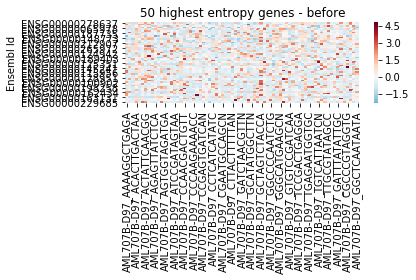

In [17]:
# get 50 most variable genes (by entropy) by highest to lowest
most_variable_genes = get_most_variable_genes(df)

generate_heatmap(df.loc[most_variable_genes], "50 highest entropy genes - before", savefig=False)

In [ ]:

num_cores = 4          # required for coexpression
min_number_genes = 6   # required for coexpression
min_correlation = 0.05  # required for mechanistic inference. Bulk RNAseq default=0.2;single cell RNAseq default=0.05

if os.path.exists(results_dir) == False:
    os.mkdir(results_dir)
    os.mkdir(results_dir+'figures')
    os.mkdir(results_dir+'info')


In [ ]:
# preprocess data
expression_data, conversion_table = miner2.preprocess.main(df)
expression_data.shape

ENSG00000206308
ENSG00000229685


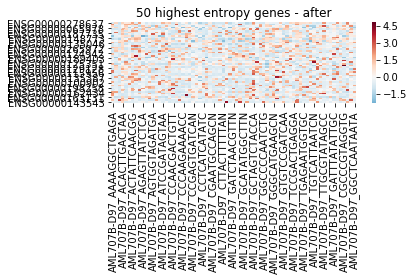

In [16]:
for i in most_variable_genes:
    if i not in expression_data.index:
        print(i)

# get 50 most variable genes (by entropy) by highest to lowest
generate_heatmap(expression_data.loc[get_most_variable_genes(expression_data)], "50 highest entropy genes - after", savefig=False)

In [ ]:
# post processed data plots
individual_expression_data = [expression_data.iloc[:,i] for i in range(50)]
plt.boxplot(individual_expression_data)
plt.title("Sample expression profiles")
plt.ylabel("Relative expression")
plt.xlabel("Sample ID")
plt.xticks(fontsize=6)

figure_name=results_dir+'figures/boxplots.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()

plt.hist(expression_data.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene")
plt.ylabel("Frequency")
plt.xlabel("Relative expression")

figure_name=results_dir+'figures/singleGene.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()

plt.hist(expression_data.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single sample",FontSize=14)
plt.ylabel("Frequency")
plt.xlabel("Relative expression")

figure_name=results_dir+'figures/singleSample.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()


In [ ]:
# STEP 1: clustering
initial_clusters = miner2.coexpression.cluster(expression_data,min_number_genes=min_number_genes,num_cores=num_cores)
revised_clusters = miner2.coexpression.revise_initial_clusters(initial_clusters,expression_data)

In [34]:
 #len(numpy.hstack([revised_clusters[i] for i in numpy.arange(10).astype(str)]))
len(df.loc[numpy.random.choice(expression_data.index,len(first_clusters),replace=False),:])

347

In [ ]:
# QC: visualize coexpression clusters

# retrieve first 10 clusters for visual inspection
first_clusters = numpy.hstack([revised_clusters[i] for i in numpy.arange(10).astype(str)])
# visualize first 10 clusters
plt.imshow(expression_data.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes")
plt.xlabel("Samples")
plt.title("First 10 coexpression clusters")
figure_name=results_dir+'figures/first.coexpression.clusters.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()
# visualize 10 random clusters
plt.imshow(expression_data.loc[numpy.random.choice(expression_data.index,len(first_clusters),replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes")
plt.xlabel("Samples")
plt.title("Random coexpression genes")
figure_name=results_dir+'figures/random.coexpression.clusters.pdf'
plt.tight_layout()
plt.savefig(figure_name)
plt.clf()

In [ ]:
# STEP 2: mechanistic inference
dill.dump_session(results_dir+'info/bottle.dill')
dill.load_session(results_dir+'info/bottle.dill')

# get first principal component axes of clusters
axes = miner2.mechanistic_inference.get_principal_df(revised_clusters,expression_data,subkey=None,min_number_genes=1)

# analyze revised clusters for enrichment in relational database 
mechanistic_output = miner2.mechanistic_inference.enrichment(axes,revised_clusters,expression_data,p=0.05,
                                                             correlation_threshold=min_correlation,num_cores=num_cores, single_cell = True)

In [ ]:
revised_clusters

In [ ]:
mechanistic_output

In [ ]:
# dill.dump_session(results_dir+'info/bottle.dill')
# dill.load_session(results_dir+'info/bottle.dill')

In [ ]:
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = mechanistic_output
expressionData = df
# create a background matrix used for statistical hypothesis testing
bkgd = miner2.miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner2.miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner2.miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner2.miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner2.miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner2.miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(results_dir,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner2.miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(results_dir,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner2.miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(results_dir,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner2.miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(results_dir,"coherentMembers.csv"))

# Get eigengenes for all modules
eigengenes = miner2.miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(results_dir,"eigengenes.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))



In [ ]:
df.shape

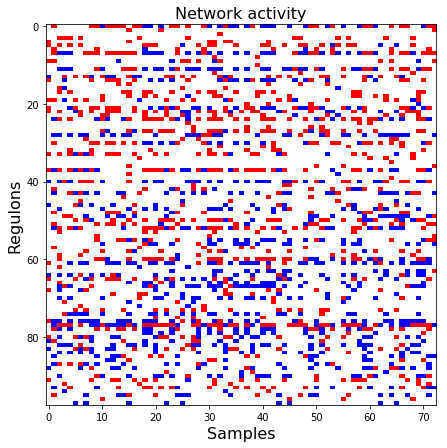

In [7]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)
plt.savefig(results_dir + "networkactivity.pdf")

In [2]:
# dill.dump_session(results_dir+'info/bottle.dill')
# dill.load_session(results_dir+'info/bottle.dill')

In [3]:
# subtype discovery
# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states, centroidClusters = miner2.miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = 
                                               int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)

Beginning subtype inference


/home/aliu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


done!
done!
done!
done!
done!
done!
completed subtype inference in 0.04 minutes


In [2]:
# dill.dump_session(results_dir+'info/bottle.dill')
dill.load_session(results_dir+'info/bottle.dill')

done!
completed in 0.02 minutes


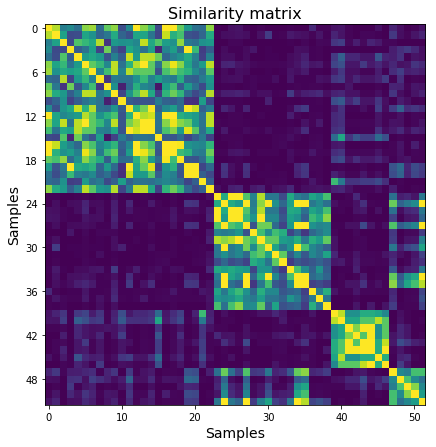

In [20]:
t1 = time.time()
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner2.miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner2.miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner2.miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(results_dir,"similarityMatrix_regulons.pdf"))
t2 = time.time()
print("completed in {:.2f} minutes".format((t2-t1)/60.))

completed in 0.01 minutes


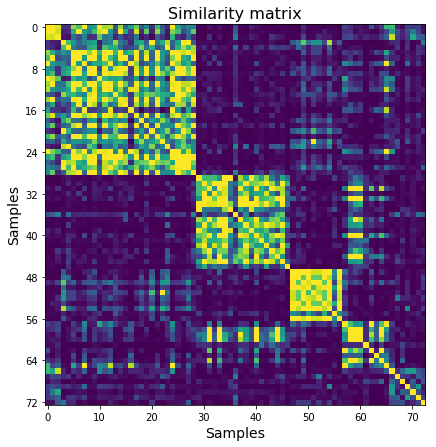

In [23]:
t1 = time.time()
# expand initial subtype clusters
centroidClusters, centroidMatrix = miner2.miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(results_dir,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner2.miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
miner2.miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(results_dir,"centroidClusters_regulons.pdf"))
t2 = time.time()
print("completed in {:.2f} minutes".format((t2-t1)/60.))

completed in 0.01 minutes


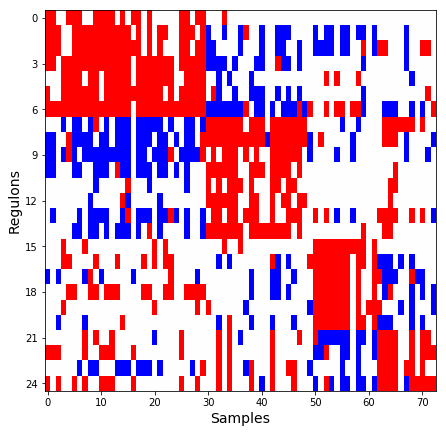

In [25]:
t1 = time.time()
# Get eigengenes for all modules
eigengenes = miner2.miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

# Generate heatmaps of module activity 
orderedOverExpressedMembers = miner2.miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Regulons",resultsDirectory=None,showplot=False)
orderedDM = miner2.miner.plotDifferentialMatrix(sampleMatrix,sampleUnderMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(results_dir,"centroid_clusters_heatmap.pdf"),showplot=True)
t2 = time.time()
print("completed in {:.2f} minutes".format((t2-t1)/60.))

Discovered 10 transcriptional states and 4 transcriptional programs
sample coverage within sufficiently large states: 100.0%
completed subtype inference in 0.01 minutes


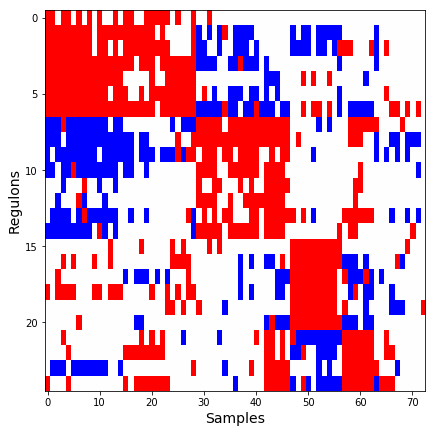

In [27]:
t1 = time.time()
# Infer transcriptional programs and states
programs, states = miner2.miner.mosaic(dfr=orderedDM,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(results_dir,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner2.miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(results_dir,"regulons_activity_heatmap.csv"))
# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(np.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(np.hstack(groups)))/expressionData.shape[1]))

#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(results_dir,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(results_dir,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    np.savetxt(os.path.join(results_dir,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
    
# Determine activity of transcriptional programs in each sample
statesDf = miner2.miner.reduceModules(df=orderedDM,programs=program_list,states=states,stateThreshold=0.65,saveFile=None)

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner2.miner.programsVsStates(statesDf,states,filename=None)

t2 = time.time()
print("completed subtype inference in {:.2f} minutes".format((t2-t1)/60.))

In [104]:
def getGeneSymbol(gene_id):
    res = gs_to_ensembl[gs_to_ensembl['Ensembl Id'].str.contains(gene_id)]
    for index, row in res.iterrows():
        return index
    return None

temp = []
program_name = 'TP1'
for indice in range(len(transcriptional_programs[program_name])):
    program = transcriptional_programs[program_name][indice]
    for key in program:
        temp.append(key)
        #temp.extend(program[key][1])

temp_gene_ids = []
for gene_id in temp:
    gene_symbol = getGeneSymbol(gene_id)
    
    if gene_symbol is not None:
        temp_gene_ids.append(getGeneSymbol(gene_id))
    
print('\n'.join(list(set(temp_gene_ids))))

DR1
RORA
EGR1
MEF2A
ETS1
ETV6
HMGA1


In [92]:
#gs_to_ensembl[gs_to_ensembl['Ensembl Id'].str.contains('ENSG00000121410')]
transcriptional_programs

{'TP0': [{'ENSG00000134954': [0.04059963890634236,
    ['ENSG00000062725',
     'ENSG00000117222',
     'ENSG00000115841',
     'ENSG00000127527',
     'ENSG00000117602',
     'ENSG00000235107',
     'ENSG00000138642',
     'ENSG00000164144',
     'ENSG00000064651']]},
  {'ENSG00000185129': [0.03948709458208455,
    ['ENSG00000172340', 'ENSG00000151657']]},
  {'ENSG00000112592': [0.03898301838301928,
    ['ENSG00000135269',
     'ENSG00000175115',
     'ENSG00000126883',
     'ENSG00000104756',
     'ENSG00000166925',
     'ENSG00000198648',
     'ENSG00000117751',
     'ENSG00000262599',
     'ENSG00000002834']]},
  {'ENSG00000185129': [0.009568111497269164,
    ['ENSG00000116678', 'ENSG00000102265', 'ENSG00000187608']]},
  {'ENSG00000118922': [0.014935837570050051,
    ['ENSG00000242259',
     'ENSG00000197714',
     'ENSG00000143093',
     'ENSG00000235107']]},
  {'ENSG00000168610': [0.02444924809498055,
    ['ENSG00000198743',
     'ENSG00000131943',
     'ENSG00000140379',
     'E